In [ ]:
import torch
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm.notebook import tqdm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

DATASET_PATH = r"D:\videos\Dataframe"
print(f"Dataset path exists: {os.path.exists(DATASET_PATH)}")

Using device: cpu
Dataset path exists: True


Loading Train data from: D:\videos\Dataframe\Train
Found 540924 Real images
Found 543675 Fake images
Loading Val data from: D:\videos\Dataframe\Val
Found 81611 Real images
Found 86482 Fake images
Loading Test data from: D:\videos\Dataframe\Test
Found 74624 Real images
Found 73779 Fake images


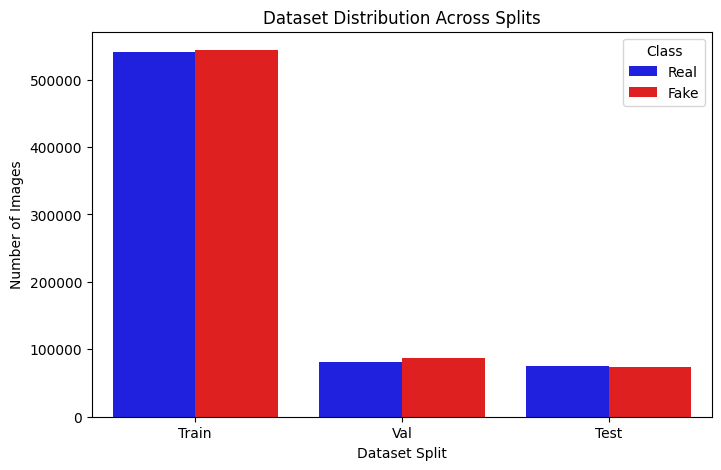

In [ ]:
class DeepfakeDataset(Dataset):
    def __init__(self, root_dir, split='Train', transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.images = []
        self.labels = []
        
        print(f"Loading {split} data from: {self.root_dir}")
        
        for label, class_name in enumerate(['Real', 'Fake']):
            class_dir = os.path.join(self.root_dir, class_name)
            if not os.path.exists(class_dir):
                raise RuntimeError(f"Directory not found: {class_dir}")
            
            files = os.listdir(class_dir)
            print(f"Found {len(files)} {class_name} images")
            
            for img_name in files:
                self.images.append(os.path.join(class_dir, img_name))
                self.labels.append(label)
                
        self.class_counts = {"Real": self.labels.count(0), "Fake": self.labels.count(1)}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(label, dtype=torch.float32)
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            return torch.zeros((3, 224, 224)), torch.tensor(0., dtype=torch.float32)

# Function to plot dataset distribution
def plot_data_distribution():
    splits = ['Train', 'Val', 'Test']
    data_counts = {split: DeepfakeDataset(DATASET_PATH, split).class_counts for split in splits}
    
    df = []
    for split, counts in data_counts.items():
        for label, count in counts.items():
            df.append([split, label, count])
    
    import pandas as pd
    df = pd.DataFrame(df, columns=['Split', 'Class', 'Count'])
    
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df, x='Split', y='Count', hue='Class', palette=['blue', 'red'])
    plt.title('Dataset Distribution Across Splits')
    plt.ylabel('Number of Images')
    plt.xlabel('Dataset Split')
    plt.legend(title='Class')
    plt.show()

# Call the function to plot
data_distribution_plot = plot_data_distribution()

def get_transforms(is_training=True):
    if is_training:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1),
            transforms.RandomApply([transforms.Grayscale(num_output_channels=3)], p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

class DeepfakeDetector(nn.Module):
    def __init__(self):
        super(DeepfakeDetector, self).__init__()
        # Use EfficientNet-B3 with pretrained weights
        self.base_model = models.efficientnet_b4(weights='IMAGENET1K_V1')
        num_features = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Identity()
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),  # Added BatchNorm
            nn.SiLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        features = self.base_model(x)
        return self.classifier(features)

In [ ]:
def train_model(config):
    model = DeepfakeDetector().to(device, memory_format=torch.channels_last)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=3e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

    try:
        train_dataset = DeepfakeDataset(
            config['data_dir'], 
            "Train", 
            transform=get_transforms(True)
        )
        val_dataset = DeepfakeDataset(
            config['data_dir'], 
            "Val", 
            transform=get_transforms(False)
        )
    except Exception as e:
        print(f"Error initializing datasets: {str(e)}")
        return

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)

    best_auc = 0.0
    early_stopping_counter = 0
    
    scaler = torch.amp.GradScaler('cuda')

    for epoch in range(config['num_epochs']):
        model.train()
        train_losses = []
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config["num_epochs"]}')
        
        for images, labels in progress_bar:
            images = images.to(device, non_blocking=True, memory_format=torch.channels_last)
            labels = labels.to(device, non_blocking=True)  
            
            optimizer.zero_grad(set_to_none=True) 
            
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_losses.append(loss.item())
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        model.eval()
        val_losses = []
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc='Validation'):
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                
                with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                    outputs = model(images).squeeze()
                    loss = criterion(outputs, labels)
                
                val_losses.append(loss.item())
                val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_auc = roc_auc_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, np.array(val_preds) > 0.5, average='weighted')
        val_acc = accuracy_score(val_labels, (np.array(val_preds) > 0.5)) 
        
        print(f'\nEpoch {epoch+1}:')
        print(f'Train Loss: {np.mean(train_losses):.4f}')
        print(f'Val Loss: {np.mean(val_losses):.4f}')
        print(f'Val AUC: {val_auc:.4f}')
        print(f'Val F1: {val_f1:.4f}')
        print(f'Val Accuracy: {val_acc:.4f}')  

        scheduler.step(val_auc)

        if val_auc > best_auc:
            best_auc = val_auc
            save_path = f"/kaggle/working/best_b3_model_epoch{epoch+1}.pth"
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_auc': best_auc,
                'scaler_state_dict': scaler.state_dict()
            }, save_path)
            
           
            !cp {save_path} /kaggle/working/best_model.pth
            !cp {save_path} /kaggle/output/  
            print(f"✅ Model saved at: {save_path} & /kaggle/output/")

        else:
            early_stopping_counter += 1

        if early_stopping_counter >= config['early_stopping_patience']:
            print(f'\nEarly stopping triggered after epoch {epoch+1}')
            break


    print(f'\nBest validation AUC: {best_auc:.4f}')
    return model

config = {
    'data_dir': DATASET_PATH,
    'batch_size': 64,
    'learning_rate': 1e-5,
    'num_epochs': 10,
    'early_stopping_patience': 5
}

In [ ]:
torch.backends.cudnn.benchmark = True  
torch.backends.cuda.matmul.allow_tf32 = True  
torch.backends.cudnn.allow_tf32 = True

model = train_model(config)

In [ ]:
import shutil 

source_path = '/kaggle/input/efficientnet_b4_model/pytorch/default/1/best_b3_model_epoch4.pth' 

destination_path = "/kaggle/working/" 

shutil.copy(source_path, destination_path) 


In [ ]:
import torch

model_path = "/kaggle/working/best_b3_model_epoch4.pth"
checkpoint = torch.load(model_path, map_location="cuda") 

model = DeepfakeDetector().to("cuda")

model.load_state_dict(checkpoint["model_state_dict"]) 
model.eval()

print("✅ Model successfully loaded!")


In [ ]:
def test_model(model, data_dir):
    test_dataset = DeepfakeDataset(data_dir, "Test", transform=get_transforms(False))
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    model.eval()
    test_preds, test_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images = images.to("cuda")
            outputs = model(images).squeeze()
            test_preds.extend(torch.sigmoid(outputs).cpu().numpy())
            test_labels.extend(labels.numpy())

    auc_score = roc_auc_score(test_labels, test_preds)
    print(f"Test AUC-ROC Score: {auc_score:.4f}")

test_model(model, DATASET_PATH)
